# Simplified Particle Transformer for Jet Classification

Each jet is a set of particles with no natural ordering. This makes it a perfect application for *self-attention*, which is permutation-equivariant and captures all pairwise interactions directly.

We use synthetic data so the notebook is fully self-contained. Ordinarily you would use a ML dataset like the one in the references.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import math

torch.manual_seed(42)
np.random.seed(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
# -- Physics parameters --
NUM_PARTICLE_FEATURES = 4   # (pT, eta, phi, E) per particle
MAX_PARTICLES = 50          # max constituents per jet (zero-padded)

# -- Classification: 3 jet types --
NUM_CLASSES = 3
CLASS_NAMES = ["light quark (q)", "gluon (g)", "top quark (t)"]

# -- Model hyperparameters --
D_MODEL  = 64     # embedding dimension
N_HEADS  = 4      # attention heads         (Page 7)
N_LAYERS = 3      # Transformer blocks      (Page 9)
D_FF     = 128    # feed-forward hidden dim
DROPOUT  = 0.1

# -- Training --
BATCH_SIZE    = 128
NUM_EPOCHS    = 20
LEARNING_RATE = 1e-3
NUM_TRAIN     = 10_000
NUM_VAL       = 2_000

## Synthetic Jet Data

We generate fake jets with random physics-inspired differences:
In a real analysis you'd use Monte Carlo generators (MadGraph, Pythia, Herwig).


In [3]:
def generate_synthetic_jet(jet_class, max_particles=MAX_PARTICLES):
    """Generate one synthetic jet. Returns (particles, mask)."""
    if jet_class == 0:      # light quark
        n_particles, pt_scale, angular_width, n_prongs = np.random.randint(10,25), 5.0, 0.2, 1
    elif jet_class == 1:    # gluon
        n_particles, pt_scale, angular_width, n_prongs = np.random.randint(20,40), 3.0, 0.4, 1
    else:                   # top quark
        n_particles, pt_scale, angular_width, n_prongs = np.random.randint(25,50), 4.0, 0.15, 3

    jet_eta = np.random.uniform(-2.0, 2.0)
    jet_phi = np.random.uniform(-np.pi, np.pi)

    particles = np.zeros((max_particles, NUM_PARTICLE_FEATURES), dtype=np.float32)
    mask = np.zeros(max_particles, dtype=bool)

    for i in range(min(n_particles, max_particles)):
        prong = np.random.randint(0, n_prongs)
        d_eta = prong * 0.3 * np.random.choice([-1, 1])
        d_phi = prong * 0.3 * np.random.choice([-1, 1])
        pt  = np.random.exponential(pt_scale)
        eta = jet_eta + d_eta + np.random.normal(0, angular_width)
        phi = jet_phi + d_phi + np.random.normal(0, angular_width)
        E   = pt * np.cosh(eta - jet_eta)  # massless approx
        particles[i] = [pt, eta, phi, E]
        mask[i] = True

    return particles, mask


class SyntheticJetDataset(Dataset):
    def __init__(self, num_jets):
        self.jets, self.masks, self.labels = [], [], []
        for _ in range(num_jets):
            label = np.random.randint(0, NUM_CLASSES)
            jet, mask = generate_synthetic_jet(label)
            self.jets.append(jet)
            self.masks.append(mask)
            self.labels.append(label)
        self.jets   = np.array(self.jets)
        self.masks  = np.array(self.masks)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.jets[idx]),
            torch.tensor(self.masks[idx]),
            torch.tensor(self.labels[idx]),
        )

### Visualize one jet of each class in the $\eta$-$\phi$ plane

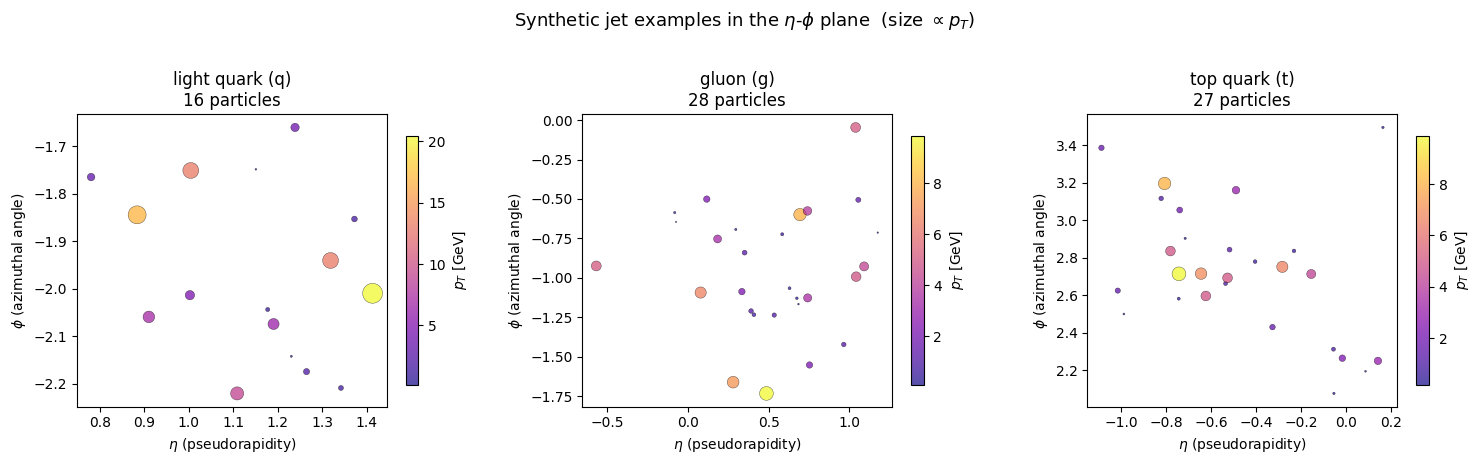

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

for cls in range(NUM_CLASSES):
    jet, mask = generate_synthetic_jet(cls)
    n = mask.sum()
    pt, eta, phi = jet[:n, 0], jet[:n, 1], jet[:n, 2]
    ax = axes[cls]
    sc = ax.scatter(eta, phi, s=pt*10, c=pt, cmap="plasma",
                    alpha=0.7, edgecolors="k", linewidths=0.3)
    ax.set_xlabel(r"$\eta$ (pseudorapidity)")
    ax.set_ylabel(r"$\phi$ (azimuthal angle)")
    ax.set_title(f"{CLASS_NAMES[cls]}\n{n} particles")
    plt.colorbar(sc, ax=ax, label=r"$p_T$ [GeV]", shrink=0.85)

plt.suptitle(r"Synthetic jet examples in the $\eta$-$\phi$ plane  (size $\propto p_T$)",
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

## Particle Transformer Classifier

We use PyTorch's built-in Transformer modules.

In [5]:
class ParticleTransformerClassifier(nn.Module):
    """
    Simplified Particle Transformer for jet classification

    Uses PyTorch's nn.TransformerEncoder, which internally implements:
      - Multi-head self-attention with Q, K, V projections
      - Residual connections + LayerNorm
      - Position-wise feed-forward network
    """

    def __init__(self, n_features=NUM_PARTICLE_FEATURES, d_model=D_MODEL,
                 n_heads=N_HEADS, n_layers=N_LAYERS, d_ff=D_FF,
                 n_classes=NUM_CLASSES, dropout=DROPOUT):
        super().__init__()

        # --- Input projection ---
        # Map raw particle kinematics (pT, eta, phi, E) into d_model space
        self.input_projection = nn.Sequential(
            nn.Linear(n_features, d_model),
            nn.GELU(),
            nn.LayerNorm(d_model),
        )

        # --- Transformer encoder (PyTorch built-in) ---
        # Each layer contains: MultiHeadAttention + FFN + residuals + norms
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            activation="gelu",       # Gaussian Error Linear Unit
            batch_first=True,        # input shape: (batch, seq, features)
            norm_first=False,        # post-norm (original Transformer style)
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=n_layers,
        )

        # --- Classification head ---
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, n_classes),
        )

    def forward(self, particles, mask):
        """
        particles : (B, max_particles, 4)
        mask      : (B, max_particles) -- True = real particle
        """
        # 1. Embed particle features into d_model space
        x = self.input_projection(particles)          # (B, N, d_model)
        x = x * mask.unsqueeze(-1).float()            # zero out padding

        # 2. Run through Transformer encoder
        padding_mask = ~mask                           # flip: True = padded
        x = self.transformer_encoder(
            x, src_key_padding_mask=padding_mask
        )                                              # (B, N, d_model)

        # 3. Masked global average pooling
        #    Aggregate per-particle representations into one jet vector
        x = x * mask.unsqueeze(-1).float()            # re-zero padding
        n_real = mask.sum(dim=1, keepdim=True).float().clamp(min=1)
        jet_vec = x.sum(dim=1) / n_real               # (B, d_model)

        # 4. Classify
        return self.classifier(jet_vec)                # (B, n_classes)

In [6]:
model = ParticleTransformerClassifier().to(DEVICE)
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {n_params:,}\n")
print(model)

Trainable parameters: 109,571

ParticleTransformerClassifier(
  (input_projection): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): GELU(approximate='none')
    (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Sequential(
    (0

## Create Datasets & Train

In [7]:
train_ds = SyntheticJetDataset(NUM_TRAIN)
val_ds   = SyntheticJetDataset(NUM_VAL)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE)

print(f"Train: {len(train_ds):,} jets  |  Val: {len(val_ds):,} jets")

Train: 10,000 jets  |  Val: 2,000 jets


In [8]:
def train_one_epoch(model, loader, opt, crit):
    model.train()
    loss_sum, correct, total = 0., 0, 0
    for parts, mask, labels in loader:
        parts, mask, labels = parts.to(DEVICE), mask.to(DEVICE), labels.to(DEVICE)
        opt.zero_grad()
        logits = model(parts, mask)
        loss = crit(logits, labels)
        loss.backward()
        opt.step()
        loss_sum += loss.item() * len(labels)
        correct  += (logits.argmax(1) == labels).sum().item()
        total    += len(labels)
    return loss_sum / total, correct / total

# Following line tells you to skip gradients for the rest of what follows:
# namely, the evaluate() function
@torch.no_grad()
def evaluate(model, loader, crit):
    model.eval()
    loss_sum, correct, total = 0., 0, 0
    for parts, mask, labels in loader:
        parts, mask, labels = parts.to(DEVICE), mask.to(DEVICE), labels.to(DEVICE)
        logits = model(parts, mask)
        loss = crit(logits, labels)
        loss_sum += loss.item() * len(labels)
        correct  += (logits.argmax(1) == labels).sum().item()
        total    += len(labels)
    return loss_sum / total, correct / total

In [9]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
criterion = nn.CrossEntropyLoss()

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(1, NUM_EPOCHS + 1):
    tl, ta = train_one_epoch(model, train_loader, optimizer, criterion)
    vl, va = evaluate(model, val_loader, criterion)
    scheduler.step()

    history["train_loss"].append(tl)
    history["val_loss"].append(vl)
    history["train_acc"].append(ta)
    history["val_acc"].append(va)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:>3d}  |  train loss {tl:.4f}  acc {ta:.1%}"
              f"  |  val loss {vl:.4f}  acc {va:.1%}")

print(f"\nBest val accuracy: {max(history['val_acc']):.1%}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Epoch   1  |  train loss 0.8145  acc 60.6%  |  val loss 0.5650  acc 74.2%
Epoch   5  |  train loss 0.3394  acc 85.2%  |  val loss 0.3520  acc 85.1%
Epoch  10  |  train loss 0.2825  acc 87.8%  |  val loss 0.2714  acc 88.6%
Epoch  15  |  train loss 0.2038  acc 91.4%  |  val loss 0.2235  acc 91.5%
Epoch  20  |  train loss 0.1823  acc 92.4%  |  val loss 0.2003  acc 92.6%

Best val accuracy: 92.6%


## Evaluating Results on the Training Data

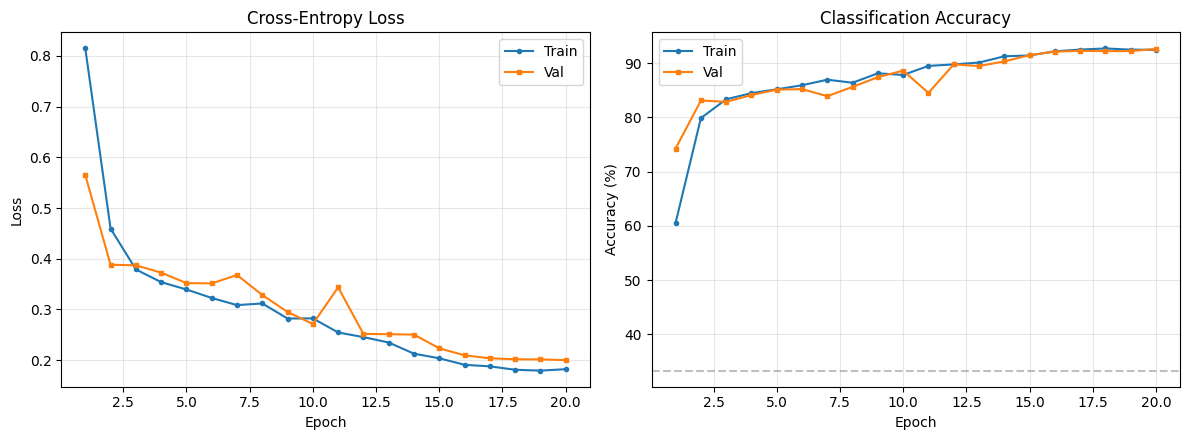

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))
epochs = range(1, NUM_EPOCHS + 1)

ax1.plot(epochs, history["train_loss"], "o-", label="Train", markersize=3)
ax1.plot(epochs, history["val_loss"],   "s-", label="Val",   markersize=3)
ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss")
ax1.set_title("Cross-Entropy Loss"); ax1.legend(); ax1.grid(alpha=0.3)

ax2.plot(epochs, [a*100 for a in history["train_acc"]], "o-", label="Train", markersize=3)
ax2.plot(epochs, [a*100 for a in history["val_acc"]],   "s-", label="Val",   markersize=3)
ax2.set_xlabel("Epoch"); ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Classification Accuracy"); ax2.legend(); ax2.grid(alpha=0.3)
ax2.axhline(100/NUM_CLASSES, ls="--", c="gray", alpha=0.5, label="Random chance")

plt.tight_layout()
plt.show()

## Confusion Matrix

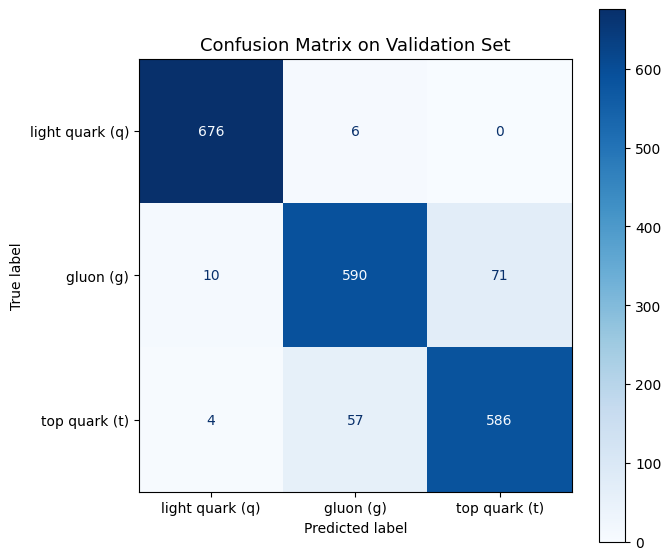

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for parts, mask, labels in val_loader:
        logits = model(parts.to(DEVICE), mask.to(DEVICE))
        all_preds.extend(logits.argmax(1).cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=CLASS_NAMES)
fig, ax = plt.subplots(figsize=(7, 6))
disp.plot(ax=ax, cmap="Blues", values_format="d")
ax.set_title("Confusion Matrix on Validation Set", fontsize=13)
plt.tight_layout()
plt.show()